# First-order Hybrid System, Hybrid MPC Demo

In [1]:
%load_ext autoreload
%autoreload 2
#%pylab notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pympc.dynamical_systems as ds
import pympc.plot as mpc_plt
from pympc.control import HybridModelPredictiveController
from pympc.geometry.polytope import Polytope

We aim to regulate to the origin the following PieceWise Affine (PWA) system with first-order dynamics ($x,u \in \mathbb R$)

\begin{equation}
\dot x =
\begin{cases}
- x + u -2, \quad & \text{if} \ -3 \leq x < -1, \\
x + u, \quad & \text{if} \ -1 \leq x \leq 1, \\
- x + u + 2, \quad & \text{if} \ 1 < x \leq 3,
\end{cases}
\end{equation}

with imput bounds $-5 \leq u \leq 5$.

Setting a sampling time $t_s$, the discrete-time PWA system can be defined from its continuous-time representation (the exact zero-order-hold discretization is used) to get the model
\begin{align}
x_{k+1} =
A_i x_k + B_i u_k + c_i, \quad \text{if} \quad x_k \in \mathcal X_i \ \text{and} \ u_k \in \mathcal U_i, \quad i = 1, \ldots , s, \\
\end{align}
with $s=3$.

In [3]:
# discretization method
method = 'explicit_euler'

# sampling time
t_s = .1

# dynamics n.1
A_0 = np.array([[-1.]])
B_0 = np.array([[1.]])
c_0 = np.array([[-2.]])
S_0 = ds.AffineSystem.from_continuous(A_0, B_0, c_0, t_s, method)

# dynamics n.2
A_1 = np.array([[1.]])
B_1 = np.array([[1.]])
c_1 = np.array([[0.]])
S_1 = ds.AffineSystem.from_continuous(A_1, B_1, c_1, t_s, method)

# dynamics n.3
A_2 = np.array([[-1.]])
B_2 = np.array([[1.]])
c_2 = np.array([[2.]])
S_2 = ds.AffineSystem.from_continuous(A_2, B_2, c_2, t_s, method)

# list of dynamics
S = [S_0, S_1, S_2]

The domains of the PWA have to be expressed as polytopes.

In [4]:
# state domain n.1
x_min_0 = np.array([[-3.]])
x_max_0 = np.array([[-1.]])
X_0 = Polytope.from_bounds(x_min_0, x_max_0)
X_0.assemble()

# state domain n.1
x_min_1 = x_max_0
x_max_1 =  - x_max_0
X_1 = Polytope.from_bounds(x_min_1, x_max_1)
X_1.assemble()

# state domain n.1
x_min_2 = x_max_1
x_max_2 = - x_min_0
X_2 = Polytope.from_bounds(x_min_2, x_max_2)
X_2.assemble()

# list of state domains
X = [X_0, X_1, X_2]

# input domain
u_max = np.array([[3.]])
u_min = -u_max
U = Polytope.from_bounds(u_min, u_max)
U.assemble()
U = [U]*3

We can now define the PWA system.

In [5]:
pwa_sys = ds.PieceWiseAffineSystem.from_orthogonal_domains(S, X, U)

At each each step, the following optimal control is solved
\begin{align}
\min \quad &
\sum_{k=0}^{N-1} (x_k^T Q x_k + u_k^T R u_k) + x_N^T P x_N \\
\text{subject to} \quad &
x_{k+1} =
A_i x_k + B_i u_k + c_i, \quad \text{if} \quad x_k \in \mathcal X_i \ \text{and} \ u_k \in \mathcal U_i, \\
& x_k \in \bigcup_{i=1}^{s} \mathcal X_i , \quad u_k \in \bigcup_{i=1}^{s} \mathcal U_i , \\
& x_N \in \mathcal X_N, \\
& x_0 \ \text{given}, \\
\end{align}
and the input $u_0$ is applied to the system.

In [6]:
# controller parameters
N = 10
Q = np.eye(A_1.shape[0])
R = np.eye(B_1.shape[1])
P = Q
objective_norm = 'two'
grb = {'OutputFlag': 0}

# terminal set and cost
P, K = ds.dare(S_1.A, S_1.B, Q, R)
X_N = ds.moas_closed_loop_from_orthogonal_domains(S_1.A, S_1.B, K, X_1, U[1])

# hybrid controller
controller = HybridModelPredictiveController(pwa_sys, N, objective_norm, Q, R, P, X_N, grb)

Computation of Maximal Invariant Constraint-Admissible Set started.
Determinedness index: 0, Convergence index: -0.12605517043, Number of facets: 2.                
Maximal Invariant Constraint-Admissible Set found.
Removing redundant facets ... minimal facets are 2.


We can now simulate the closed-loop dynamics startion from the initial state $x_0$.

In [7]:
N_sim = 50
x_0 = np.array([[2.9]])
u = []
x = [x_0]
for k in range(N_sim):
    u.append(controller.feedback(x[k]))
    x_next = pwa_sys.simulate(x[k], [u[k]])[0][1]
    x.append(x_next)

We can use the plot functions to visualize the time evolution of the system.

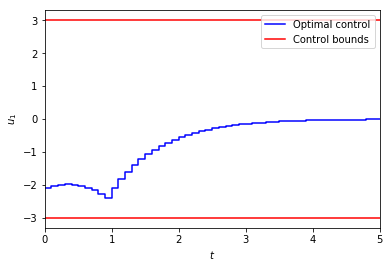

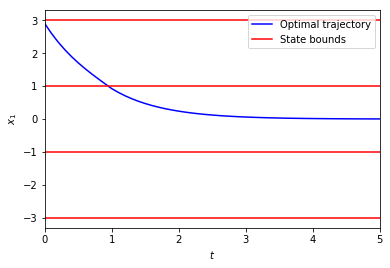

In [8]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min_0, x_min_1, x_min_2, x_max_2))
plt.show()